**Problem**: 

Approximating the non-linear data space that makes up a PyPSA simulation. Specifically, approximating a modified IEEE 13 bus topology with a uniform (grid) input. The approximation is time sensitive.

**Objective**:

This notebook will only look at [random forest](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) (RF) models. Per [1], the approximation should have a root mean sqaure error < 0.002 to ensure the approximation is not the largest source of error in the simulation. A standard linear regression will also be calculated for baseline comparison. Since the approximation is time sensitive, a search for the ball park number of samples required for reasonable scores is performed. Once the number of samples to produce reasonable results is found, a grid search can be ran to determine optimal training parameters.

**Hypothesis**: 

Previously, a linear regression model outperformed a non-linear model (artificial neural network) when tested on simple, small radial networks [2]. Since the modified IEEE 13 bus network contains two transformers whos behaviour can become non-linear if their power limit is exceeded (which is allowed in power flow [3]), I suspect there are two possible scenarios:

1. Transformer limit not exceeded: Linear regression outperforms RF model
2. Transformer limit exceeded: RF outperforms linear regressor because a RF model can capture non-linearity 

As for the number of samples required, historically 1e5-1e6 samples produces K-fold cross validation scores with low variance if the feature-label correlation is reasonable.

**Experimental Procedure**:

1. Determine the number of samples required to return reasonable scores with SVR K-fold cross validation. Reasonable scores is defined as:
  * R2 > 0.8
  * RMSE < 0.002
  * K-fold R2 variance one degree of magnitude less than R2
2. Using approximately that number of samples, run grid search to determine optimal parameters/hyperparameters

**Results**:

* Testing different sample sizes

| n_samples         |        100 |       1000 |       10000 |       100000 |
|:------------------|-----------:|-----------:|------------:|-------------:|
| rf_fit_time       | 0.124259   | 0.825855   | 10.8118     | 145.014      |
| rf_score_time     | 0.0288108  | 0.042241   |  0.48812    |   6.37943    |
| rf_test_r2        | 0.414773   | 0.588604   |  0.644128   |   0.816647   |
| rf_test_rmse      | 0.00304963 | 0.00267007 |  0.00247768 |   0.00177921 |
| rf_test_mae       | 0.00226547 | 0.00190567 |  0.00170158 |   0.00105475 |
| rf_test_maxae     | 0.0144659  | 0.0166441  |  0.0251789  |   0.0260118  |
| linear_fit_time   | 0.00410957 | 0.00195227 |  0.00799651 |   0.134568   |
| linear_score_time | 0.00166116 | 0.00310507 |  0.0118873  |   0.208881   |
| linear_test_r2    | 0.571123   | 0.661088   |  0.663526   |   0.664543   |
| linear_test_rmse  | 0.00263566 | 0.00243879 |  0.00241882 |   0.00241745 |
| linear_test_mae   | 0.00184378 | 0.00169448 |  0.00166478 |   0.00166503 |
| linear_test_maxae | 0.0140767  | 0.0175159  |  0.0247341  |   0.0266285  |

* With outlier removal

Scores with outliers removed by 1-sigma filter: 
r2 score: 0.4404498935663021
rmse score: 0.003034414566557147
mae score: 0.0021592306465658987
maxae score: 0.035390213912141255


Scores with all data (incl. outliers): 
r2 score: 0.6081998730762346
rmse score: 0.0025391462103004363
mae score: 0.0017673716999786135
maxae score: 0.027288566908512002


Scores with outliers removed by 2-sigma filter: 
r2 score: 0.5925082825055584
rmse score: 0.0025894934456937415
mae score: 0.0018033819467131692
maxae score: 0.03320194821203448


Scores with all data (incl. outliers): 
r2 score: 0.610869572762153
rmse score: 0.00253048063774992
mae score: 0.0017622837122290849
maxae score: 0.02927787708931051


Scores with outliers removed by 3-sigma filter: 
r2 score: 0.6164294160372116
rmse score: 0.0025123380160403997
mae score: 0.001746826357674079
maxae score: 0.030153409116718932


Scores with all data (incl. outliers): 
r2 score: 0.6115149513901053
rmse score: 0.002528381346988403
mae score: 0.0017568386856197083
maxae score: 0.03159176440636857


Scores with outliers removed by 4-sigma filter: 
r2 score: 0.6175159883119533
rmse score: 0.002508777038023244
mae score: 0.0017428954539859967
maxae score: 0.030179614116119247


Scores with all data (incl. outliers): 
r2 score: 0.6115996800150866
rmse score: 0.0025281056118504745
mae score: 0.0017562971945968868
maxae score: 0.03096774043314543


Scores with outliers removed by 5-sigma filter: 
r2 score: 0.6174213385182905
rmse score: 0.0025090874307891384
mae score: 0.0017437805133288754
maxae score: 0.02922835862930573


Scores with all data (incl. outliers): 
r2 score: 0.6113852914221456
rmse score: 0.002528803245458144
mae score: 0.0017584102241693942
maxae score: 0.028532719258111516


* Normalising the input:


| n_samples         |       100000 |
|:------------------|-------------:|
| rf_fit_time       | 151.992      |
| rf_score_time     |   6.01919    |
| rf_test_r2        |   0.637793   |
| rf_test_rmse      |   0.00244126 |
| rf_test_mae       |   0.00156085 |
| rf_test_maxae     |   0.0292717  |

* Permutation importance

| Weight          | Feature |
|-----------------|---------|
| 0.9104 ± 0.0853 | x5      |
| 0.5800 ± 0.0346 | x6      |
| 0.1351 ± 0.0108 | x1      |
| 0.0541 ± 0.0024 | x3      |
| 0.0539 ± 0.0046 | x2      |
| 0.0511 ± 0.0022 | x8      |
| 0.0501 ± 0.0028 | x0      |

* Principle component analysis

| n_components = 1  |      100000 |
|:------------------|------------:|
| rf_fit_time       | 44.9403     |
| rf_score_time     |  6.55428    |
| rf_test_r2        |  0.477186   |
| rf_test_rmse      |  0.00297056 |
| rf_test_mae       |  0.00188972 |
| rf_test_maxae     |  0.0360935  |

| n_components = 2  |      100000 |
|:------------------|------------:|
| rf_fit_time       | 49.6014     |
| rf_score_time     |  6.23458    |
| rf_test_r2        |  0.736134   |
| rf_test_rmse      |  0.00211407 |
| rf_test_mae       |  0.00128355 |
| rf_test_maxae     |  0.0295565  |


| n_components = 3  |      100000 |
|:------------------|------------:|
| rf_fit_time       | 61.4906     |
| rf_score_time     |  6.12341    |
| rf_test_r2        |  0.775859   |
| rf_test_rmse      |  0.00194902 |
| rf_test_mae       |  0.00118029 |
| rf_test_maxae     |  0.0269413  |

| n_components = 4  |      100000 |
|:------------------|------------:|
| rf_fit_time       | 74.3325     |
| rf_score_time     |  5.71738    |
| rf_test_r2        |  0.793577   |
| rf_test_rmse      |  0.00188306 |
| rf_test_mae       |  0.00113203 |
| rf_test_maxae     |  0.0276649  |

| n_components = 5  |      100000 |
|:------------------|------------:|
| rf_fit_time       | 89.4412     |
| rf_score_time     |  5.71935    |
| rf_test_r2        |  0.797644   |
| rf_test_rmse      |  0.00186955 |
| rf_test_mae       |  0.00112346 |
| rf_test_maxae     |  0.0273177  |

Running a randomized grid search with 1e5 samples produced the following results:

1. n_estimators: 99, max_depth: 73, mean training time: 226s (mean R2: 0.85 std dev: 0.0006)
2. n_estimators: 89, max_depth: 62, mean training time: 208s (mean R2: 0.85 std dev: 0.0006)
3. .
4. .


18. n_estimators: 24, max_depth: 68, mean training time: 54s (mean R2: 0.84 std dev: 0.001)
19. n_estimators: 3, max_depth: 19, mean training time: 7s (mean R2: 0.77 std dev: 0.001)
20. n_estimators: 36, max_depth: 9, mean training time: 55s (mean R2: 0.74 std dev: 0.002)

**Discussion**:

One approach to reduce the cost of simulation-based research is to copy the underlying model and evaluate the approximation [1][4].

It takes roughly 7 hours to create 1e5 samples (by running PyPSA sim) on Intel(R) Xeon(R) CPU E5-2650 v4 @ 2.20GHz


**Bibliography**

[1] https://github.com/mbardwell/masters

[2] Enhancing Power Flow Simulations Using Function Mapping. Michael Bardwell ; Petr Musilek. 2019 IEEE Canadian Conference on Electrical and Computer Engineering (CCECE)

[3] https://groups.google.com/forum/#!searchin/pypsa/mikey%7Csort:date/pypsa/FqfC_UR85k0/vBc7HYP_EQAJ

[4] ieee-13_timing-pfsim-vs-evaluating-models.ipynb


Table of Contents:
* Source data
* Analyse data
* Setup models
* Determine number of samples to get reasonable scores
* Search

In [2]:
import copy
import csv
import importlib
import logging
import sys
import time
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pypsa
import seaborn as sns

warnings.filterwarnings('ignore')
logger = logging.getLogger("pypsa")
logger.setLevel("WARNING")
%matplotlib inline

In [102]:
def personalise_column_names(df, name):
        new_columns = []
        for column in df.columns:
            new_columns.append(name + "-" + str(column))
        df.columns = new_columns
        return pd.DataFrame(df)


def collect_data(path_to_powerflow_data, data):
    '''
    Assumes folder tree has
    path_to_powerflow_data/
    -->datafiles
    -->results/
    '''
    import pandas as pd
    
    data["loads"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "loads-p_set.csv"), "load")
    data["vmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vmags.csv"), "vmag")
    data["vangs"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "vangs.csv"), "vang")
    data["qmags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "qmags.csv"), "qmag")
    data["linemags"] = personalise_column_names(pd.read_csv(path_to_powerflow_data + "results/" + "linemags.csv"), "linemag")


def set_gaussian_sample_size(path_to_powerflow_data, data_to_change, n_samples, seed=None):
    '''
    Parameters
    ----------
    data_to_change: list of strings.
        ex: ["loads-p_set", "generators-p_max_pu", "snapshots"]
    '''
    import numpy as np
    import pandas as pd
    
    n_original_samples = 2  # sample_1 from IEEE-13 paper, sample_2=0.9*sample_1

    data = {}
    for datatype in data_to_change:
        data[datatype] = pd.read_csv(path_to_powerflow_data + datatype + ".csv")

    def increase_data(dataframe, n_samples, seed=None):
        addon = {}
        new_df_list = []
        for idx, column in enumerate(dataframe):
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                addon[column] = np.abs(
                    np.random.RandomState(seed=seed).normal(loc=dataframe[column][0:n_original_samples].mean(),
                                                            scale=dataframe[column][0:n_original_samples].std(),
                                                            size=n_samples))
            elif dataframe[column].dtype == object:
                # assuming object is datetime column
                latest_datetime = pd.to_datetime(dataframe[column][n_original_samples-1])
                addon[column] = []
                for sample in range(n_samples):
                    addon[column].append(latest_datetime + pd.Timedelta(hours=(1+sample)))
            else:
                raise TypeError("dataframe[column] type: {} should be object or float64/int64".format(
                    type(dataframe[column].dtype)))
        addon_dataframe = pd.DataFrame(addon)
        return dataframe.head(n_original_samples).append(addon_dataframe)

    def cap_data(dataframe, min_value, max_value):
        for column in dataframe:
            if dataframe[column].dtype == np.float64 or dataframe[column].dtype == np.int64:
                for i, val in enumerate(dataframe[column]):
                    if val > max_value:
                        dataframe[column][i] = max_value
                    elif val < min_value:
                        dataframe[column][i] = min_value
        return dataframe

    if n_samples > n_original_samples:
        for datatype in data:
            data[datatype] = increase_data(data[datatype], n_samples-n_original_samples, seed)
            if datatype == "generators-p_max_pu":
                data[datatype] = cap_data(data[datatype], 0, 1)

    for datatype in data:
        data[datatype].to_csv(path_to_powerflow_data + datatype + ".csv", index=False)
        print("Datatype {} stored".format(datatype))


def create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None):
    import os
    from pathlib import Path
    import shutil
    
    import pypsa

    if not os.path.isdir(path_to_powerflow_data):
        src = Path(path_to_powerflow_data).parents[0] / "ieee-13-with-load-gen/"  # original modified IEEE model
        shutil.copytree(src, path_to_powerflow_data)

    set_gaussian_sample_size(path_to_powerflow_data, data_to_change, sample_size, seed=None)

    network = pypsa.Network(import_name=path_to_powerflow_data)
    network.pf()

    save_path = path_to_powerflow_data + "results/"
    network.buses_t.v_mag_pu.to_csv(save_path + "vmags.csv")
    network.buses_t.v_ang.to_csv(save_path + "vangs.csv")
    network.buses_t.q.to_csv(save_path + "qmags.csv")
    network.lines_t.p0.to_csv(save_path + "linemags.csv")


def backup_samples(src, dest):
    '''
    thanks https://www.pythoncentral.io/how-to-recursively-copy-a-directory-folder-in-python/
    '''
    import errno
    import os
    import shutil

    try:
        if os.path.isdir(dest):
            shutil.rmtree(dest)
        shutil.copytree(src, dest)
        print("Backup to {} successful".format(dest))
    except OSError as e:
        # If the error was caused because the source wasn't a directory
        if e.errno == errno.ENOTDIR:
            shutil.copy(src, dest)
        else:
            print('Directory not copied. Error: %s' % e)


def add_mean_and_std_rows(dataframe):
    mean = dataframe.mean()
    std = dataframe.std()
    dataframe.loc["mean"] = mean
    dataframe.loc["std"] = std
    return dataframe


def maxae(y, y_pred, **kwargs):
    import numpy as np
    return max(np.abs(y-y_pred).ravel())

def rmse(y, y_pred, **kwargs):
    import operator
    return np.sqrt(np.mean(np.square(list(map(operator.sub, y, y_pred)))))

def set_data_size(features, labels, n_samples, n_training_samples):
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val, train_idx, test_idx = train_test_split(features,
                                                                           labels,
                                                                           range(features.shape[0]),
                                                                           train_size=n_training_samples,
                                                                           test_size=n_samples-n_training_samples,
                                                                           random_state=None)

    X_train = X_train.values
    y_train = y_train.values
    X_val = X_val.values
    y_val = y_val.values

    return X_train, y_train, X_val, y_val, test_idx, train_idx

def train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000], prompt=True):
    """
    Trains regression model on a variety of sample sizes
    
    parameters
    ----------
    features: pandas DataFrame
    labels: pandas DataFrame
    n_sample_array: array
        ex: [100, 1000, 10000, 100000]
    regression_model: sklearn regressor
        ex: RandomForestRegressor
    """
    import datetime

    from sklearn.linear_model import LinearRegression
    from sklearn.metrics import make_scorer, r2_score
    from sklearn.metrics import mean_absolute_error as mae
    from sklearn.model_selection import cross_validate, train_test_split
    from tabulate import tabulate
    
    if prompt:
        savefile_descriptor_addon = input("Add on extra descriptor to saved file (ex: -testing_maxae)? ")
    else:
        savefile_descriptor_addon = ''
    linear = LinearRegression()
    common_cross_validate_variables = {"cv": 5,
                                       "n_jobs": -1,
                                       "scoring": {"r2": make_scorer(r2_score), 
                                                   "rmse": make_scorer(rmse),
                                                   "mae": make_scorer(mae),
                                                   "maxae": make_scorer(maxae)}}
    summary = {}

    for i, n_samples in enumerate(n_samples_array):
        current_iteration = i

        # do not split data into train/val; cross_validate will automatically do that
        samples_to_use = np.random.randint(0, features.shape[0], n_samples)
        X = features.iloc[samples_to_use].values
        y = labels.iloc[samples_to_use].values
        
        print("\n\nRun: ", current_iteration)
        print("n_samples for k fold cross validation: ", n_samples)
        print("n_features: ", X.shape[1])
        print("n_labels: ", y.shape[1])

        ## regression model to evaluate
        print("\n\n{} REGRESSION\n\n".format(regression_model_name.upper()))
        time_start = time.time()
        regression_model_results = pd.DataFrame(cross_validate(regression_model, X, y, 
                                                               **common_cross_validate_variables))
        time_regression_model = time.time()
        print("cross validation training time {:.5}".format(time_regression_model-time_start))
        print("cross validation training scores: ")
        regression_model_results.columns = [regression_model_name+"_"+col for col in regression_model_results.columns]
        regression_model_results = add_mean_and_std_rows(regression_model_results)
        display(regression_model_results)

        print("non-cross validation model scores for reference:")
        n_training_samples = int(n_samples*80/100)
        X_train, y_train, X_val, y_val, _, _ = set_data_size(features, labels, n_samples, n_training_samples)
        regression_model.fit(X_train, y_train)
        print("n_training_samples: ", n_training_samples)
        print("n_validation_samples: ", n_samples-n_training_samples)
        print("training score: ", r2_score(y_train, regression_model.predict(X_train)))
        print("validation score: ", r2_score(y_val, regression_model.predict(X_val)))
        print("rmse: ", rmse(regression_model.predict(X_val), y_val))



        ## linear regression for baseline comparison
        print("\n\nLINEAR REGRESSION\n\n")
        time_start = time.time()
        linear_results = pd.DataFrame(cross_validate(linear, X, y, **common_cross_validate_variables))
        time_linear = time.time()
        print("cross validation training time {:.5}".format(time_linear-time_start))
        print("cross validation training scores: ")
        linear_results.columns = ["linear_"+col for col in linear_results.columns]
        linear_results = add_mean_and_std_rows(linear_results)
        display(linear_results)

        linear.fit(X_train, y_train)
        print("non-cross validation model scores for reference:")
        print("training score: ", r2_score(y_train, linear.predict(X_train)))
        print("validation score: ", r2_score(y_val, linear.predict(X_val)))
        print("rmse: ", rmse(linear.predict(X_val), y_val))



        ## save models
        datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
        results_to_save = regression_model_results.join(linear_results)
        results_to_save.to_csv(path_to_powerflow_data + 
                               "/results/approximating_with_{}_model_results-{}_samples-gaussian_input-{}{}.csv".format(
                                   regression_model_name,
                                   n_samples, 
                                   datetimestamp,
                                   savefile_descriptor_addon))
        
        summary[n_samples] = results_to_save.loc["mean"].values

    summary = pd.DataFrame(summary, index=results_to_save.columns)
    summary_table = tabulate(summary, tablefmt="pipe", headers="keys")
    print("\n\nSUMMARY\n\n", summary_table)
    with open(path_to_powerflow_data + "/results/approximating_with_{}_model_summary-gaussian_input-{}{}.txt".format(
                  regression_model_name,
                  datetimestamp,
                  savefile_descriptor_addon), "w") as f:
        f.write(summary_table)

# Source Data

In [55]:
## USER INPUT
sample_size = 100000 # this is the max number of samples available

data_to_change = ["loads-p_set", "snapshots", "loads-q_set"]

path_to_powerflow_example = "../../pypsa/examples/ieee-13/"
path_to_powerflow_data = (path_to_powerflow_example + "/ieee-13-with-load-gen-gaussian-data-" +
                          str(sample_size) + "-samples/")
path_to_powerflow_results = path_to_powerflow_data + "results/"

In [56]:
## Uncomment to generate load samples for modified IEEE-13 network
# if sample_size > 10000:
#     user = input("Are you sure [y/n]? This could erase hours worth of data")
#     if user == "y":
#         backup_samples(path_to_powerflow_results, path_to_powerflow_data + "results-backup/")
#         create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)
# else:
#     create_samples_and_run_network(path_to_powerflow_data, data_to_change, sample_size, seed=None)

data = {"loads": [], "vmags": [], "vangs": [], "qmags": [], "linemags": []}
collect_data(path_to_powerflow_data, data)

# Analyse Data

In [57]:
features = data["loads"].drop("load-name", axis=1)
labels = data["vmags"].drop(["vmag-name", "vmag-Substation"], axis=1)
features_and_labels = features.join(labels)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc36b84c890>,
      dtype=object)

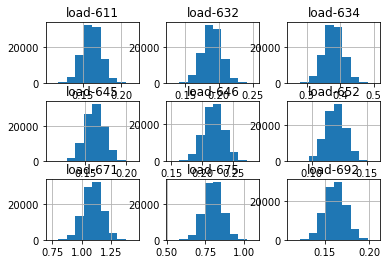

In [58]:
features.hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fc36b8101d0>,
      dtype=object)

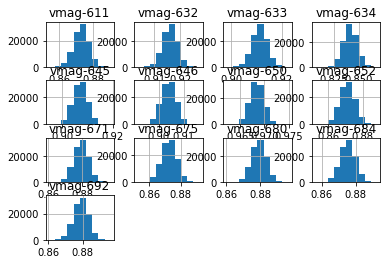

In [59]:
labels.hist()

In [60]:
corr_matrix = labels.join(features).corr()

# only loads for columns
cols = [c for i, c in enumerate(corr_matrix.columns) if corr_matrix.keys().str.contains("^load", regex=True)[i]]
reduced_corr_matrix = corr_matrix[cols]
reduced_corr_matrix["row average"] = pd.Series(reduced_corr_matrix.mean(axis=1))
# only voltages for rows
rows = reduced_corr_matrix.index[reduced_corr_matrix.index.str.contains("load")]
reduced_corr_matrix.drop(rows, inplace=True)
reduced_corr_matrix = reduced_corr_matrix.append(pd.Series(reduced_corr_matrix.mean(), name="column average"))

display(reduced_corr_matrix)

,load-632,load-634,load-645,load-646,load-652,load-671,load-675,load-692,load-611,row average
vmag-650,-0.020046,-0.132160,-0.021454,-0.021495,-0.019223,-0.137006,-0.110304,-0.024238,-0.023217,-0.056572
vmag-646,-0.086474,-0.228395,-0.174776,-0.298769,-0.067853,-0.547298,-0.412960,-0.084970,-0.085142,-0.220738
vmag-645,-0.088140,-0.233107,-0.178247,-0.228672,-0.069011,-0.558910,-0.421875,-0.086483,-0.086819,-0.216807
vmag-632,-0.090864,-0.241835,-0.086768,-0.103492,-0.071260,-0.579590,-0.437670,-0.089086,-0.089764,-0.198925
vmag-633,-0.087539,-0.351729,-0.083343,-0.099481,-0.069388,-0.557443,-0.421417,-0.085484,-0.085808,-0.204626
vmag-634,-0.038337,-0.264779,-0.040705,-0.041729,-0.031290,-0.253145,-0.190968,-0.039854,-0.040087,-0.104544
vmag-611,-0.059673,-0.159657,-0.060138,-0.066237,-0.110490,-0.682213,-0.512931,-0.104191,-0.181470,-0.215222
vmag-684,-0.059961,-0.160856,-0.060472,-0.066622,-0.111234,-0.686586,-0.516017,-0.104635,-0.144018,-0.212267
vmag-671,-0.060145,-0.162090,-0.060937,-0.067011,-0.083057,-0.691941,-0.519826,-0.105176,-0.106685,-0.206319
vmag-692,-0.060137,-0.162069,-0.060930,-0.067001,-0.083047,-0.691848,-0.519997,-0.105211,-0.106673,-0.206324


# Determine number of samples to get reasonable scores

In [61]:
# setup model parameters/hyperparameters

'''
dnn hyperparameters are chosen from sandbox testing. On average the model attempts to converge 
(with other parameters it sometimes gives up early).
'''
from sklearn.ensemble import RandomForestRegressor

regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model_name = "rf"

In [136]:
train_models_on_given_sample_size(regression_model, features, labels, n_samples_array=[100, 1000, 10000, 100000])

Add on extra descriptor to saved file (ex: -testing_maxae)? no


Run:  0
n_samples for k fold cross validation:  10
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 0.35708
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,0.076372,0.029394,-4.041733,0.000864,0.000527,0.003487
1,0.068832,0.022342,-7.113384,0.002125,0.001661,0.003933
2,0.077792,0.042646,-3.925563,0.004851,0.003869,0.014644
3,0.066168,0.049398,-351.636270,0.001694,0.001358,0.003881
4,0.062488,0.039302,-299.289965,0.002690,0.002407,0.005254
mean,0.070331,0.036616,-133.201383,0.002445,0.001965,0.006240
std,0.006581,0.010757,176.487856,0.001501,0.001260,0.004745


non-cross validation model scores for reference:
n_training_samples:  8
n_validation_samples:  2
training score:  0.847037369199652
validation score:  0.03497912405730065
rmse:  0.0045496561408353885


LINEAR REGRESSION


cross validation training time 0.025027
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.001094,0.001143,-74.537961,0.003692,0.002461,0.013064
1,0.001250,0.003202,-806.548384,0.016163,0.014120,0.028565
2,0.000737,0.001080,-812.947495,0.054003,0.042586,0.118949
3,0.000690,0.001082,-152498.428753,0.038038,0.028280,0.118378
4,0.000616,0.000964,-168.631679,0.002818,0.002316,0.008874
mean,0.000877,0.001494,-30872.218855,0.022943,0.017953,0.057566
std,0.000278,0.000957,67991.997109,0.022440,0.017411,0.056255


non-cross validation model scores for reference:
training score:  1.0
validation score:  -114.33448775167417
rmse:  0.03313077679674021


Run:  1
n_samples for k fold cross validation:  100
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 0.47783
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,0.120773,0.028136,0.472382,0.002621,0.001982,0.013422
1,0.123469,0.027487,0.589175,0.002998,0.002180,0.013021
2,0.121908,0.045683,0.529600,0.002980,0.002109,0.017450
3,0.116894,0.036991,0.061218,0.002996,0.002238,0.014129
4,0.129726,0.027276,0.279653,0.003455,0.002519,0.017330
mean,0.122554,0.033115,0.386406,0.003010,0.002205,0.015070
std,0.004688,0.008117,0.215729,0.000296,0.000200,0.002155


non-cross validation model scores for reference:
n_training_samples:  80
n_validation_samples:  20
training score:  0.9308661430629533
validation score:  0.5058536006809089
rmse:  0.002447156942380102


LINEAR REGRESSION


cross validation training time 0.056885
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.001121,0.001352,0.589988,0.002245,0.001520,0.013640
1,0.001029,0.001383,0.707613,0.002483,0.001648,0.016597
2,0.001023,0.001161,0.646234,0.002633,0.001891,0.018252
3,0.001078,0.001370,0.420303,0.002387,0.001667,0.013344
4,0.000729,0.001451,0.487703,0.002979,0.001918,0.021570
mean,0.000996,0.001343,0.570368,0.002545,0.001729,0.016681
std,0.000155,0.000109,0.116544,0.000281,0.000171,0.003419


non-cross validation model scores for reference:
training score:  0.716213326159638
validation score:  0.6237232245259071
rmse:  0.002134492596662164


SUMMARY

 |                   |              10 |        100 |
|:------------------|----------------:|-----------:|
| rf_fit_time       |      0.0703306  | 0.122554   |
| rf_score_time     |      0.0366165  | 0.0331146  |
| rf_test_r2        |   -133.201      | 0.386406   |
| rf_test_rmse      |      0.00244477 | 0.00301007 |
| rf_test_mae       |      0.00196458 | 0.00220548 |
| rf_test_maxae     |      0.00623979 | 0.0150702  |
| linear_fit_time   |      0.00087738 | 0.00099597 |
| linear_score_time |      0.00149422 | 0.00134325 |
| linear_test_r2    | -30872.2        | 0.570368   |
| linear_test_rmse  |      0.0229427  | 0.00254548 |
| linear_test_mae   |      0.0179526  | 0.0017288  |
| linear_test_maxae |      0.0575661  | 0.0166805  |


# Try different feature preprocessing

In [84]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer

# test normalizing labels
estimators = [("normalise", Normalizer()),
              ('regression', regression_model)]
preprocessed_model = Pipeline(estimators)
train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[100000])

Add on extra descriptor to saved file (ex: -testing_maxae)? -normalised_inputs


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 475.7
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,153.875281,5.932143,0.637177,0.002433,0.001560,0.027139
1,152.561436,6.294808,0.639960,0.002437,0.001557,0.029437
2,149.776759,5.658828,0.633469,0.002458,0.001568,0.026920
3,150.460783,5.819415,0.643095,0.002425,0.001546,0.031620
4,153.287055,6.390744,0.635263,0.002453,0.001573,0.031242
mean,151.992263,6.019188,0.637793,0.002441,0.001561,0.029272
std,1.788861,0.312796,0.003817,0.000014,0.000011,0.002208


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9002041849787135
validation score:  0.28117266994230283
rmse:  0.003427523667950598


LINEAR REGRESSION


cross validation training time 3.1393
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.577047,0.200674,0.658344,0.002419,0.001668,0.026092
1,0.115414,0.211838,0.664823,0.002425,0.001662,0.026766
2,0.111729,0.215991,0.661817,0.002423,0.001669,0.026110
3,0.190370,0.188705,0.659786,0.002436,0.001679,0.026804
4,0.134244,0.207136,0.664758,0.002412,0.001663,0.028172
mean,0.225761,0.204869,0.661906,0.002423,0.001668,0.026789
std,0.198878,0.010680,0.002908,0.000009,0.000007,0.000845


non-cross validation model scores for reference:
training score:  0.6631622616863727
validation score:  0.6603767378935336
rmse:  0.002422863041469911


SUMMARY

 |                   |       100000 |
|:------------------|-------------:|
| rf_fit_time       | 151.992      |
| rf_score_time     |   6.01919    |
| rf_test_r2        |   0.637793   |
| rf_test_rmse      |   0.00244126 |
| rf_test_mae       |   0.00156085 |
| rf_test_maxae     |   0.0292717  |
| linear_fit_time   |   0.225761   |
| linear_score_time |   0.204869   |
| linear_test_r2    |   0.661906   |
| linear_test_rmse  |   0.00242279 |
| linear_test_mae   |   0.00166827 |
| linear_test_maxae |   0.0267888  |


In [83]:
# test outlier removal
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as mae

def find_outliers(df, m=3):
    """
    Thanks https://stackoverflow.com/questions/21448225/getting-indices-of-true-values-in-a-boolean-list
    """
    from itertools import compress
    
    import numpy as np
    
    outliers = []
    for col in df:
        data = df[col]
        positions = abs(data - np.mean(data)) > m * np.std(df[col])
        outliers.append(list(compress(range(len(positions.values)), positions.values)))
    
    flat_list = np.unique([item for sublist in outliers for item in sublist])
    return flat_list

def test_find_outliers():
    import pandas as pd
    y_train = pd.DataFrame([[1,2,3,4,5],
                            [2,3,4,5,6],
                            [3,4,5,6,7]])
    return list(find_outliers(y_train, m=1)) == [0, 2] and list(find_outliers(y_train, m=2)) == []

if not test_find_outliers():
    assert(False)

X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 100000, 80000)

for sigma in [1,2,3,4,5]:
    # find outliers in labels (voltages). If there is an outlier at any node remove the sample from the data set 
    outliers = find_outliers(pd.DataFrame(y_train), m=sigma)

    outlier_free_X_train = np.array([e for i, e in enumerate(X_train) if i not in outliers])
    outlier_free_y_train = np.array([e for i, e in enumerate(y_train) if i not in outliers])

    estimators = [('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.fit(outlier_free_X_train, outlier_free_y_train)
    print("\n\nScores with outliers removed by {}-sigma filter: ".format(sigma))
    print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
    print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
    print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
    print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))
    
    samples_to_use = np.random.randint(0, np.array(X_train).shape[0], outlier_free_X_train.shape[0])
    X_train_same_number_samples_as_outlier_free = pd.DataFrame(X_train).iloc[samples_to_use].values
    y_train_same_number_samples_as_outlier_free = pd.DataFrame(y_train).iloc[samples_to_use].values

    estimators = [('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.fit(X_train_same_number_samples_as_outlier_free, y_train_same_number_samples_as_outlier_free)
    print("\n\nScores with all data (incl. outliers): ".format(sigma))
    print("r2 score: {}".format(preprocessed_model.score(X_test, y_test)))
    print("rmse score: {}".format(rmse(preprocessed_model.predict(X_test), y_test)))
    print("mae score: {}".format(mae(preprocessed_model.predict(X_test), y_test)))
    print("maxae score: {}".format(maxae(preprocessed_model.predict(X_test), y_test)))



Scores with outliers removed by 1-sigma filter: 
r2 score: 0.4404498935663021
rmse score: 0.003034414566557147
mae score: 0.0021592306465658987
maxae score: 0.035390213912141255


Scores with all data (incl. outliers): 
r2 score: 0.6081998730762346
rmse score: 0.0025391462103004363
mae score: 0.0017673716999786135
maxae score: 0.027288566908512002


Scores with outliers removed by 2-sigma filter: 
r2 score: 0.5925082825055584
rmse score: 0.0025894934456937415
mae score: 0.0018033819467131692
maxae score: 0.03320194821203448


Scores with all data (incl. outliers): 
r2 score: 0.610869572762153
rmse score: 0.00253048063774992
mae score: 0.0017622837122290849
maxae score: 0.02927787708931051


Scores with outliers removed by 3-sigma filter: 
r2 score: 0.6164294160372116
rmse score: 0.0025123380160403997
mae score: 0.001746826357674079
maxae score: 0.030153409116718932


Scores with all data (incl. outliers): 
r2 score: 0.6115149513901053
rmse score: 0.002528381346988403
mae score: 0.001

In [104]:
# test dimensionality reduction

# first determine how many features to drop
import eli5
X_train, y_train, X_test, y_test, _, _ = set_data_size(features, labels, 1000, 800)
regression_model = RandomForestRegressor(n_estimators=100, max_depth=None)
regression_model.fit(X_train, y_train)
perm = eli5.sklearn.PermutationImportance(regression_model, random_state=1).fit(X_train, y_train)
display(eli5.show_weights(perm))


# drop features using pca. Centre number of features around perm importance results, which is 3 features
from sklearn.decomposition import PCA

for n_features in [1,2,3,4,5]:
    estimators = [("pca", PCA()),
                  ('regression', regression_model)]
    preprocessed_model = Pipeline(estimators)
    preprocessed_model.set_params(pca__n_components=n_features)
    train_models_on_given_sample_size(preprocessed_model, features, labels, n_samples_array=[100000], prompt=False)

Weight,Feature
0.9104 ± 0.0853,x5
0.5800 ± 0.0346,x6
0.1351 ± 0.0108,x1
0.0541 ± 0.0024,x3
0.0539 ± 0.0046,x2
0.0511 ± 0.0022,x8
0.0501 ± 0.0028,x0
0.0459 ± 0.0044,x7
0.0430 ± 0.0016,x4




Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 168.36
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,51.063625,6.047257,0.738921,0.002102,0.001278,0.026894
1,50.108573,6.139742,0.735965,0.002116,0.001286,0.031112
2,48.687012,6.387817,0.734366,0.002119,0.001283,0.028867
3,48.196170,5.913771,0.731674,0.002127,0.001292,0.029412
4,49.951375,6.684309,0.739743,0.002106,0.001279,0.031498
mean,49.601351,6.234579,0.736134,0.002114,0.001284,0.029557
std,1.154186,0.305262,0.003311,0.000010,0.000005,0.001856


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9283508115354299
validation score:  0.48855192981536966
rmse:  0.002948983260264578


LINEAR REGRESSION


cross validation training time 1.4309
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.236396,0.212268,0.663619,0.002419,0.001664,0.026283
1,0.230044,0.207291,0.657281,0.002441,0.001682,0.025273
2,0.151900,0.201597,0.664431,0.002426,0.001665,0.028306
3,0.148471,0.200430,0.663284,0.002419,0.001667,0.028224
4,0.123347,0.205913,0.667226,0.002418,0.001666,0.025534
mean,0.178032,0.205500,0.663168,0.002425,0.001669,0.026724
std,0.051621,0.004747,0.003638,0.000010,0.000008,0.001455


non-cross validation model scores for reference:
training score:  0.6625430352822904
validation score:  0.662842151625444
rmse:  0.002429935349548591


SUMMARY

 |                   |      100000 |
|:------------------|------------:|
| rf_fit_time       | 49.6014     |
| rf_score_time     |  6.23458    |
| rf_test_r2        |  0.736134   |
| rf_test_rmse      |  0.00211407 |
| rf_test_mae       |  0.00128355 |
| rf_test_maxae     |  0.0295565  |
| linear_fit_time   |  0.178032   |
| linear_score_time |  0.2055     |
| linear_test_r2    |  0.663168   |
| linear_test_rmse  |  0.00242486 |
| linear_test_mae   |  0.00166866 |
| linear_test_maxae |  0.0267242  |


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 209.3
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,61.719341,6.512179,0.770796,0.001970,0.001191,0.028566
1,61.645916,6.416672,0.773884,0.001962,0.001187,0.027680
2,60.917179,5.948511,0.780709,0.001923,0.001162,0.025491
3,61.611201,5.819875,0.779860,0.001936,0.001175,0.027651
4,61.559282,5.919811,0.774046,0.001954,0.001186,0.025318
mean,61.490584,6.123409,0.775859,0.001949,0.001180,0.026941
std,0.325775,0.316749,0.004253,0.000019,0.000012,0.001451


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9390700370099386
validation score:  0.563631123993027
rmse:  0.002716336335245981


LINEAR REGRESSION


cross validation training time 1.2891
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.207929,0.210054,0.659628,0.002436,0.001681,0.028236
1,0.194711,0.204710,0.663907,0.002424,0.001670,0.026751
2,0.119295,0.211266,0.660463,0.002425,0.001671,0.024289
3,0.107027,0.206197,0.662773,0.002426,0.001675,0.028298
4,0.111432,0.207285,0.659625,0.002426,0.001679,0.026201
mean,0.148079,0.207902,0.661279,0.002427,0.001675,0.026755
std,0.049024,0.002712,0.001954,0.000005,0.000005,0.001656


non-cross validation model scores for reference:
training score:  0.6627849261846617
validation score:  0.6618038909268418
rmse:  0.0024268269847817934


SUMMARY

 |                   |      100000 |
|:------------------|------------:|
| rf_fit_time       | 61.4906     |
| rf_score_time     |  6.12341    |
| rf_test_r2        |  0.775859   |
| rf_test_rmse      |  0.00194902 |
| rf_test_mae       |  0.00118029 |
| rf_test_maxae     |  0.0269413  |
| linear_fit_time   |  0.148079   |
| linear_score_time |  0.207902   |
| linear_test_r2    |  0.661279   |
| linear_test_rmse  |  0.00242734 |
| linear_test_mae   |  0.00167524 |
| linear_test_maxae |  0.026755   |


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 239.81
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,75.286373,5.816095,0.795658,0.001875,0.001129,0.029986
1,75.041183,5.626776,0.789985,0.001899,0.001144,0.025581
2,74.031703,5.832996,0.796502,0.001869,0.001118,0.031028
3,73.847305,5.887408,0.790026,0.001885,0.001130,0.026617
4,73.455949,5.423605,0.795711,0.001887,0.001139,0.025112
mean,74.332503,5.717376,0.793577,0.001883,0.001132,0.027665
std,0.791571,0.191399,0.003277,0.000012,0.000010,0.002676


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9425513715741146
validation score:  0.5939933934652444
rmse:  0.002646767560040764


LINEAR REGRESSION


cross validation training time 1.0998
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.170956,0.192108,0.664739,0.002415,0.001662,0.026163
1,0.199448,0.201695,0.660968,0.002431,0.001675,0.025543
2,0.109709,0.186168,0.661821,0.002428,0.001664,0.028335
3,0.131276,0.168493,0.657886,0.002427,0.001668,0.024635
4,0.095788,0.188255,0.664276,0.002440,0.001682,0.028208
mean,0.141436,0.187344,0.661938,0.002428,0.001670,0.026577
std,0.043100,0.012106,0.002770,0.000009,0.000008,0.001640


non-cross validation model scores for reference:
training score:  0.6626393070674431
validation score:  0.6625000066573127
rmse:  0.002426639344680641


SUMMARY

 |                   |      100000 |
|:------------------|------------:|
| rf_fit_time       | 74.3325     |
| rf_score_time     |  5.71738    |
| rf_test_r2        |  0.793577   |
| rf_test_rmse      |  0.00188306 |
| rf_test_mae       |  0.00113203 |
| rf_test_maxae     |  0.0276649  |
| linear_fit_time   |  0.141436   |
| linear_score_time |  0.187344   |
| linear_test_r2    |  0.661938   |
| linear_test_rmse  |  0.0024283  |
| linear_test_mae   |  0.00167015 |
| linear_test_maxae |  0.0265768  |


Run:  0
n_samples for k fold cross validation:  100000
n_features:  9
n_labels:  13


RF REGRESSION


cross validation training time 286.9
cross validation training scores: 


,rf_fit_time,rf_score_time,rf_test_r2,rf_test_rmse,rf_test_mae,rf_test_maxae
0,88.960391,5.830247,0.802590,0.001849,0.001113,0.030552
1,89.575397,5.473330,0.795402,0.001869,0.001122,0.024348
2,88.778250,5.642744,0.790149,0.001904,0.001143,0.026848
3,88.403215,5.862692,0.801521,0.001849,0.001110,0.025046
4,91.488596,5.787717,0.798559,0.001878,0.001130,0.029795
mean,89.441170,5.719346,0.797644,0.001870,0.001123,0.027318
std,1.220444,0.161178,0.005038,0.000023,0.000013,0.002775


non-cross validation model scores for reference:
n_training_samples:  80000
n_validation_samples:  20000
training score:  0.9437478908058095
validation score:  0.6077307611020948
rmse:  0.0026049150606530496


LINEAR REGRESSION


cross validation training time 1.1832
cross validation training scores: 


,linear_fit_time,linear_score_time,linear_test_r2,linear_test_rmse,linear_test_mae,linear_test_maxae
0,0.188396,0.216302,0.670750,0.002398,0.001650,0.028117
1,0.197415,0.192640,0.661665,0.002420,0.001665,0.024642
2,0.119720,0.179484,0.656980,0.002450,0.001688,0.026181
3,0.118516,0.203470,0.664518,0.002420,0.001671,0.025327
4,0.113289,0.179219,0.664921,0.002433,0.001678,0.028320
mean,0.147467,0.194223,0.663767,0.002424,0.001671,0.026517
std,0.041672,0.015952,0.005028,0.000019,0.000014,0.001648


non-cross validation model scores for reference:
training score:  0.6614925716499267
validation score:  0.6671086508811701
rmse:  0.002412978792379462


SUMMARY

 |                   |      100000 |
|:------------------|------------:|
| rf_fit_time       | 89.4412     |
| rf_score_time     |  5.71935    |
| rf_test_r2        |  0.797644   |
| rf_test_rmse      |  0.00186955 |
| rf_test_mae       |  0.00112346 |
| rf_test_maxae     |  0.0273177  |
| linear_fit_time   |  0.147467   |
| linear_score_time |  0.194223   |
| linear_test_r2    |  0.663767   |
| linear_test_rmse  |  0.00242443 |
| linear_test_mae   |  0.00167057 |
| linear_test_maxae |  0.0265174  |


# Search

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 600)

In [17]:
n_samples = 100000
if n_samples < 100000:
    raise ValueError("So you don't accidentally run this on 100 samples again")

n_training_samples = int(n_samples*(80/100))
X_train, y_train, X_val, y_val = set_data_size(n_samples, n_training_samples)
# remove bad label
y_train = y_train.T[1:].T
y_val = y_val.T[1:].T

In [18]:
rf = RandomForestRegressor()
params = {"n_estimators": range(100), 
          "max_depth": [None]+[i for i in range(1, 100)]}
grid = RandomizedSearchCV(rf, params, cv=3, n_iter=10, n_jobs=-1, refit=False,
                          scoring={"r2": make_scorer(r2_score), "rmse": make_scorer(rmse), "mae": make_scorer(mae)}, 
                          iid=False, verbose=10)

grid.fit(X_train, y_train)

print("\n\nRF\n\n")
grid_results = pd.DataFrame(grid.cv_results_)
display(grid_results.sort_values(by=["rank_test_r2"]))
datetimestamp = datetime.datetime.now().strftime("%Y-%m-%d-%H-%M")
filepath = (path_to_powerflow_data + 
            "/results/approximating_with_rf_grid_results-{}_samples-{}.csv".format(n_samples, datetimestamp))
print("Saving to ", filepath)
grid_results.to_csv(filepath)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.7min
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:  6.8min




RF




[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:  9.5min finished


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1


Saving to  ../../pypsa/examples/ieee-13//ieee-13-with-load-gen-uniform-data-100000-samples//results/approximating_with_rf_grid_results-100000_samples-2019-09-13-07-25.csv


In [19]:
# for reading values if you closed the notebook
imported_results = pd.read_csv(filepath)
display(imported_results.sort_values(by=["rank_test_r2"]))

,Unnamed: 0,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_max_depth,params,split0_test_r2,split1_test_r2,split2_test_r2,mean_test_r2,std_test_r2,rank_test_r2,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse
0,0,66.531391,0.622077,2.545954,0.086762,80,29,"{'n_estimators': 80, 'max_depth': 29}",0.921858,0.922751,0.922099,0.922236,0.000377,1,0.002894,0.002883,0.002889,0.002889,0.000004,10
5,5,59.921115,0.734938,2.203448,0.029155,72,98,"{'n_estimators': 72, 'max_depth': 98}",0.921811,0.921741,0.921164,0.921572,0.000290,2,0.002894,0.002901,0.002907,0.002901,0.000005,9
7,7,52.694661,0.098162,2.040517,0.075283,64,33,"{'n_estimators': 64, 'max_depth': 33}",0.921495,0.921932,0.921088,0.921505,0.000345,3,0.002899,0.002897,0.002909,0.002902,0.000005,8
9,9,42.708556,0.272464,1.667782,0.055191,52,71,"{'n_estimators': 52, 'max_depth': 71}",0.920678,0.921160,0.921027,0.920955,0.000203,4,0.002914,0.002911,0.002911,0.002912,0.000001,7
6,6,49.611883,0.197651,1.920520,0.055440,60,93,"{'n_estimators': 60, 'max_depth': 93}",0.920492,0.921506,0.920086,0.920695,0.000597,5,0.002919,0.002905,0.002928,0.002917,0.000009,6
4,4,32.702112,0.183965,1.336063,0.059603,40,74,"{'n_estimators': 40, 'max_depth': 74}",0.918704,0.919897,0.919109,0.919237,0.000495,6,0.002951,0.002934,0.002942,0.002942,0.000007,5
1,1,20.698034,0.078871,0.903889,0.030214,25,73,"{'n_estimators': 25, 'max_depth': 73}",0.915674,0.917252,0.916619,0.916515,0.000648,7,0.003008,0.002984,0.002990,0.002994,0.000010,4
2,2,19.139486,0.097723,0.843532,0.018133,23,66,"{'n_estimators': 23, 'max_depth': 66}",0.915774,0.915434,0.915281,0.915496,0.000206,8,0.003007,0.003020,0.003011,0.003013,0.000005,3
3,3,8.422979,0.240346,0.468810,0.022842,10,48,"{'n_estimators': 10, 'max_depth': 48}",0.903202,0.904700,0.903273,0.903725,0.000690,9,0.003218,0.003203,0.003221,0.003214,0.000008,2
8,8,6.304425,0.014633,0.322273,0.010596,23,4,"{'n_estimators': 23, 'max_depth': 4}",0.475762,0.463664,0.459374,0.466267,0.006939,10,0.007396,0.007507,0.007516,0.007473,0.000054,1
